In [1]:
import torch, sklearn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os, re, glob, h5py, matplotlib, shutil, math
import torch.utils.data as utils
import scipy

print('Scipy Version: ', scipy.__version__)

print(torch.__version__)

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils import data
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from torch.autograd import Variable
from torch.distributions import Categorical
from astropy.io import fits
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic, norm
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, brier_score_loss, \
    auc, roc_curve, log_loss, confusion_matrix, precision_recall_curve, average_precision_score
from triplet_utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from torch.utils.data.sampler import BatchSampler
from scipy import signal, stats
import math

from BBBlayers import BBBConv2d, BBBConv1d, BBBLinearFactorial, FlattenLayer

Scipy Version:  1.5.4
0.4.1


In [2]:
# from scipy.misc import imresize
from PIL import Image, ImageFilter
import tempfile
import os, re, matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal, stats
from numpy import (amin, amax, ravel, asarray, arange, ones, newaxis,
                   transpose, iscomplexobj, uint8, issubdtype, array)

In [3]:
def toimage(arr, high=255, low=0, cmin=None, cmax=None, pal=None,
            mode=None, channel_axis=None):
    """Takes a np array and returns a PIL image.
    This function is only available if Python Imaging Library (PIL) is installed.
    The mode of the PIL image depends on the array shape and the `pal` and
    `mode` keywords.
    For 2-D arrays, if `pal` is a valid (N,3) byte-array giving the RGB values
    (from 0 to 255) then ``mode='P'``, otherwise ``mode='L'``, unless mode
    is given as 'F' or 'I' in which case a float and/or integer array is made.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Notes
    -----
    For 3-D arrays, the `channel_axis` argument tells which dimension of the
    array holds the channel data.
    For 3-D arrays if one of the dimensions is 3, the mode is 'RGB'
    by default or 'YCbCr' if selected.
    The np array must be either 2 dimensional or 3 dimensional.
    """
    data = asarray(arr)
    if iscomplexobj(data):
        raise ValueError("Cannot convert a complex-valued array.")
    shape = list(data.shape)
    valid = len(shape) == 2 or ((len(shape) == 3) and
                                ((3 in shape) or (4 in shape)))
    if not valid:
        raise ValueError("'arr' does not have a suitable array shape for "
                         "any mode.")
    if len(shape) == 2:
        shape = (shape[1], shape[0])  # columns show up first
        if mode == 'F':
            data32 = data.astype(np.float32)
            image = Image.frombytes(mode, shape, data32.tostring())
            return image
        if mode in [None, 'L', 'P']:
            bytedata = bytescale(data, high=high, low=low,
                                 cmin=cmin, cmax=cmax)
            image = Image.frombytes('L', shape, bytedata.tostring())
            if pal is not None:
                image.putpalette(asarray(pal, dtype=uint8).tostring())
                # Becomes a mode='P' automagically.
            elif mode == 'P':  # default gray-scale
                pal = (arange(0, 256, 1, dtype=uint8)[:, newaxis] *
                       ones((3,), dtype=uint8)[newaxis, :])
                image.putpalette(asarray(pal, dtype=uint8).tostring())
            return image
        if mode == '1':  # high input gives threshold for 1
            bytedata = (data > high)
            image = Image.frombytes('1', shape, bytedata.tostring())
            return image
        if cmin is None:
            cmin = amin(ravel(data))
        if cmax is None:
            cmax = amax(ravel(data))
        data = (data*1.0 - cmin)*(high - low)/(cmax - cmin) + low
        if mode == 'I':
            data32 = data.astype(np.uint32)
            image = Image.frombytes(mode, shape, data32.tostring())
        else:
            raise ValueError(_errstr)
        return image

    # if here then 3-d array with a 3 or a 4 in the shape length.
    # Check for 3 in datacube shape --- 'RGB' or 'YCbCr'
    if channel_axis is None:
        if (3 in shape):
            ca = np.flatnonzero(asarray(shape) == 3)[0]
        else:
            ca = np.flatnonzero(asarray(shape) == 4)
            if len(ca):
                ca = ca[0]
            else:
                raise ValueError("Could not find channel dimension.")
    else:
        ca = channel_axis

    numch = shape[ca]
    if numch not in [3, 4]:
        raise ValueError("Channel axis dimension is not valid.")

    bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
    if ca == 2:
        strdata = bytedata.tostring()
        shape = (shape[1], shape[0])
    elif ca == 1:
        strdata = transpose(bytedata, (0, 2, 1)).tostring()
        shape = (shape[2], shape[0])
    elif ca == 0:
        strdata = transpose(bytedata, (1, 2, 0)).tostring()
        shape = (shape[2], shape[1])
    if mode is None:
        if numch == 3:
            mode = 'RGB'
        else:
            mode = 'RGBA'

    if mode not in ['RGB', 'RGBA', 'YCbCr', 'CMYK']:
        raise ValueError(_errstr)

    if mode in ['RGB', 'YCbCr']:
        if numch != 3:
            raise ValueError("Invalid array shape for mode.")
    if mode in ['RGBA', 'CMYK']:
        if numch != 4:
            raise ValueError("Invalid array shape for mode.")

    # Here we know data and mode is correct
    image = Image.frombytes(mode, shape, strdata)
    return image

def fromimage(im, flatten=False, mode=None):
    """
    Return a copy of a PIL image as a np array.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    im : PIL image
        Input image.
    flatten : bool
        If true, convert the output to grey-scale.
    mode : str, optional
        Mode to convert image to, e.g. ``'RGB'``.  See the Notes of the
        `imread` docstring for more details.
    Returns
    -------
    fromimage : ndarray
        The different colour bands/channels are stored in the
        third dimension, such that a grey-image is MxN, an
        RGB-image MxNx3 and an RGBA-image MxNx4.
    """
    if not Image.isImageType(im):
        raise TypeError("Input is not a PIL image.")

    if mode is not None:
        if mode != im.mode:
            im = im.convert(mode)
    elif im.mode == 'P':
        # Mode 'P' means there is an indexed "palette".  If we leave the mode
        # as 'P', then when we do `a = array(im)` below, `a` will be a 2-D
        # containing the indices into the palette, and not a 3-D array
        # containing the RGB or RGBA values.
        if 'transparency' in im.info:
            im = im.convert('RGBA')
        else:
            im = im.convert('RGB')

    if flatten:
        im = im.convert('F')
    elif im.mode == '1':
        # Workaround for crash in PIL. When im is 1-bit, the call array(im)
        # can cause a seg. fault, or generate garbage. See
        # https://github.com/scipy/scipy/issues/2138 and
        # https://github.com/python-pillow/Pillow/issues/350.
        #
        # This converts im from a 1-bit image to an 8-bit image.
        im = im.convert('L')

    a = array(im)
    return a

def bytescale(data, cmin=None, cmax=None, high=255, low=0):
    """
    Byte scales an array (image).
    Byte scaling means converting the input image to uint8 dtype and scaling
    the range to ``(low, high)`` (default 0-255).
    If the input image already has dtype uint8, no scaling is done.
    This function is only available if Python Imaging Library (PIL) is installed.
    Parameters
    ----------
    data : ndarray
        PIL image data array.
    cmin : scalar, optional
        Bias scaling of small values. Default is ``data.min()``.
    cmax : scalar, optional
        Bias scaling of large values. Default is ``data.max()``.
    high : scalar, optional
        Scale max value to `high`.  Default is 255.
    low : scalar, optional
        Scale min value to `low`.  Default is 0.
    Returns
    -------
    img_array : uint8 ndarray
        The byte-scaled array.
    Examples
    --------
    >>> from scipy.misc import bytescale
    >>> img = np.array([[ 91.06794177,   3.39058326,  84.4221549 ],
    ...                 [ 73.88003259,  80.91433048,   4.88878881],
    ...                 [ 51.53875334,  34.45808177,  27.5873488 ]])
    >>> bytescale(img)
    array([[255,   0, 236],
           [205, 225,   4],
           [140,  90,  70]], dtype=uint8)
    >>> bytescale(img, high=200, low=100)
    array([[200, 100, 192],
           [180, 188, 102],
           [155, 135, 128]], dtype=uint8)
    >>> bytescale(img, cmin=0, cmax=255)
    array([[91,  3, 84],
           [74, 81,  5],
           [52, 34, 28]], dtype=uint8)
    """
    if data.dtype == uint8:
        return data

    if high > 255:
        raise ValueError("`high` should be less than or equal to 255.")
    if low < 0:
        raise ValueError("`low` should be greater than or equal to 0.")
    if high < low:
        raise ValueError("`high` should be greater than or equal to `low`.")

    if cmin is None:
        cmin = data.min()
    if cmax is None:
        cmax = data.max()

    cscale = cmax - cmin
    if cscale < 0:
        raise ValueError("`cmax` should be larger than `cmin`.")
    elif cscale == 0:
        cscale = 1

    scale = float(high - low) / cscale
    bytedata = (data - cmin) * scale + low
    return (bytedata.clip(low, high) + 0.5).astype(uint8)

def imresize(arr, size, interp='bilinear', mode=None):
    """
    Resize an image.
    This function is only available if Python Imaging Library (PIL) is installed.
    .. warning::
        This function uses `bytescale` under the hood to rescale images to use
        the full (0, 255) range if ``mode`` is one of ``None, 'L', 'P', 'l'``.
        It will also cast data for 2-D images to ``uint32`` for ``mode=None``
        (which is the default).
    Parameters
    ----------
    arr : ndarray
        The array of image to be resized.
    size : int, float or tuple
        * int   - Percentage of current size.
        * float - Fraction of current size.
        * tuple - Size of the output image (height, width).
    interp : str, optional
        Interpolation to use for re-sizing ('nearest', 'lanczos', 'bilinear',
        'bicubic' or 'cubic').
    mode : str, optional
        The PIL image mode ('P', 'L', etc.) to convert `arr` before resizing.
        If ``mode=None`` (the default), 2-D images will be treated like
        ``mode='L'``, i.e. casting to long integer.  For 3-D and 4-D arrays,
        `mode` will be set to ``'RGB'`` and ``'RGBA'`` respectively.
    Returns
    -------
    imresize : ndarray
        The resized array of image.
    See Also
    --------
    toimage : Implicitly used to convert `arr` according to `mode`.
    scipy.ndimage.zoom : More generic implementation that does not use PIL.
    """
    im = toimage(arr, mode=mode)
    ts = type(size)
    if issubdtype(ts, np.signedinteger):
        percent = size / 100.0
        size = tuple((array(im.size)*percent).astype(int))
    elif issubdtype(type(size), np.floating):
        size = tuple((array(im.size)*size).astype(int))
    else:
        size = (size[1], size[0])
    func = {'nearest': 0, 'lanczos': 1, 'bilinear': 2, 'bicubic': 3, 'cubic': 3}
    imnew = im.resize(size, resample=func[interp])
    return fromimage(imnew)

In [4]:
test_KIC_file = '/home/z3384751/PycharmProjects/AstroBlasto/TestKIC(GOTY).txt'

ratio_data = pd.read_csv('/home/z3384751/AstroBlasto/Population_Ratio.dat', header=0, delim_whitespace=True)
ratio_index = ratio_data['val'].values
ratio_dnu = ratio_data['dnu'].values
ratio_heb_ratio = ratio_data['heb/rgb'].values
ratio_rgb_ratio = ratio_data['rgb/heb'].values
heb_fraction_weight = ratio_rgb_ratio/(ratio_heb_ratio+ratio_rgb_ratio)
rgb_fraction_weight = 1-heb_fraction_weight
print('HeB Fraction Weight: ', heb_fraction_weight)
print('Ratio Dnu: ', ratio_dnu)
class npz_generator(data.Dataset):
    def __init__(self, root, dim=(2000,), extension='.npz', select_kic=np.array([]),external_label=None, obs_len=82, do_perturb=True, external_kic = None):
        self.root = root  # root folder containing subfolders
        self.extension = extension  # file extension
        self.filenames = []
        self.external_label = external_label # is all Elsworth labels
        self.dim = dim  # image/2D array dimensions
        self.perturb_factor = np.sqrt(365. * 4. / obs_len)
        self.do_perturb = do_perturb
        self.external_kic = external_kic # is synced with Elsworth labels
        self.kic = []
        self.label = []

        for dirpath, dirnames, filenames in os.walk(root):
            for file in filenames:
                if file.endswith(extension):
                    file_kicz = int(file.split('-')[0])
                    if file_kicz in select_kic:
                        self.filenames.append(os.path.join(dirpath, file))
                        self.kic.append(file_kicz)
                        if self.external_label is not None:
                            self.label.append(self.external_label[np.where(self.external_kic == file_kicz)[0]])

        self.kic = np.array(self.kic)
        self.filenames = np.array(self.filenames)
        if self.external_label is not None:
            self.label = np.array(self.label)

        self.indexes = np.arange(len(self.kic))
        #self.indexes = self.indexes[np.in1d(self.kic, select_kic)]

        print('Number of files: ', len(self.filenames))
        print('Number of unique IDs: ', len(select_kic))

    def __len__(self):
        'Total number of samples'
        return len(self.indexes)

    def __getitem__(self, index):
        # Get a list of filenames of the batch
        batch_filenames = self.filenames[index]
        batch_kic = self.kic[index]

        X, y, dnu_vec, flag_vec = self.__data_generation(batch_filenames)
        if self.external_label is not None:
            batch_label = self.label[index]
            return X, batch_label, dnu_vec, flag_vec, batch_kic
        else:
            return X, y, dnu_vec, flag_vec, batch_kic

    def __supergausswindow(self, interval):
        window = signal.general_gaussian(2000, p=3, sig=650)
        window = window / np.max(window)
        return np.multiply(interval, window)

    def __echelle(self, lower_limit_index, upper_limit_index, freq, dnu, power):
        modulo = []
        for i in range(lower_limit_index, upper_limit_index):
            modulo.append((np.remainder(freq[i], dnu) / dnu)[0])

        return modulo, power[lower_limit_index: upper_limit_index]

    def __create_folded_spectra(self, freq, power, dnu, dnu_err, numax, numax_err):
        if self.do_perturb:
            dnu_perturb = np.random.normal(loc=dnu, scale=dnu_err * self.perturb_factor)
            numax_perturb = np.random.normal(loc=numax, scale=numax_err * self.perturb_factor)
        else:
            dnu_perturb = dnu
            numax_perturb = numax
        lower_limit_index = np.argmin(np.abs(freq - (numax_perturb - 2 * dnu_perturb)))
        upper_limit_index = np.argmin(np.abs(freq - (numax_perturb + 2 * dnu_perturb)))
        if not lower_limit_index:
            lower_limit_index = 0
        if not upper_limit_index:
            upper_limit_index = len(freq) - 1

        eps, mod_power = self.__echelle(lower_limit_index, upper_limit_index, freq, dnu_perturb, power)
        mod_power = mod_power[np.argsort(eps)]
        eps = np.sort(eps)
        if mod_power.shape[0] == 0:
            return np.zeros(self.dim), [0.]
        reshape_pow = mod_power.reshape((len(mod_power), 1))

        resize = imresize(reshape_pow, size=(1000, 1), interp='lanczos')
        resize = np.append(resize, resize)
        resize = self.__supergausswindow(resize)
        assert resize.shape == self.dim, 'Folded Spectra is of Wrong Shape!'

        if np.max(resize, axis=0) == 0:
            return np.zeros(self.dim), [0.]
        resize /= np.max(resize, axis=0)
        return resize, dnu_perturb

    def __data_generation(self, batch_filenames):

        data = np.load(batch_filenames)
        freq = data['freq']
        power = data['power']
        numax = data['numax']
        numax_err = data['numax_err']
        dnu = data['dnu']
        dnu_err = data['dnu_err']
        y = data['pop']
        flag_vec = 0

        folded_spectra, dnu_perturb = self.__create_folded_spectra(freq, power, dnu, dnu_err, numax, numax_err)
        if (dnu_perturb == 0):  # focus training on overlapping region
            flag_vec = 1
        elif dnu > 9.:
            flag_vec = 2

        X = folded_spectra
        dnu_perturb = np.round(dnu_perturb, 2)
        return X, y, dnu_perturb, flag_vec


class OneD_Stack_Bayesian(nn.Module):
    def __init__(self, kernel_size, feature_maps, padding):
        super(OneD_Stack_Bayesian, self).__init__()
        self.kernel_size = kernel_size
        self.feature_maps = feature_maps
        self.padding = padding

        self.conv1 = BBBConv1d(1, self.feature_maps ** 1, kernel_size=self.kernel_size,
                               padding=self.padding)  # same padding 2P = K-1
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool1d(2, 2)

        self.conv2 = BBBConv1d(self.feature_maps ** 1, self.feature_maps ** 2, kernel_size=self.kernel_size,
                               padding=self.padding)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool1d(2, 2)

        self.conv3 = BBBConv1d(self.feature_maps ** 2, self.feature_maps ** 3, kernel_size=self.kernel_size,
                               padding=self.padding)
        self.soft3 = nn.Softplus()
        self.pool3 = nn.MaxPool1d(2, 2)
        self.flatten = FlattenLayer(250 * 8)

        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2, self.conv3, self.soft3,
                  self.pool3,
                  self.flatten]

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        kl = 0
        for layer in self.layers:
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
                kl += _kl
            else:
                x = layer(x)
        return x, kl

class OneD_Stack(nn.Module):
    def __init__(self, kernel_size, feature_maps, padding):
        super(OneD_Stack, self).__init__()
        self.kernel_size = kernel_size
        self.feature_maps = feature_maps
        self.padding = padding

        self.conv1 = nn.Conv1d(1, self.feature_maps ** 1, kernel_size=self.kernel_size,
                               padding=self.padding)  # same padding 2P = K-1
        self.pool1 = nn.MaxPool1d(2, 2)

        self.conv2 = nn.Conv1d(self.feature_maps ** 1, self.feature_maps ** 2, kernel_size=self.kernel_size,
                               padding=self.padding)
        self.pool2 = nn.MaxPool1d(2, 2)

        self.conv3 = nn.Conv1d(self.feature_maps ** 2, self.feature_maps ** 3, kernel_size=self.kernel_size,
                               padding=self.padding)
        self.pool3 = nn.MaxPool1d(2, 2)
        self.flatten = FlattenLayer(250 * 8)

        layers = [self.conv1, self.pool1, self.conv2, self.pool2, self.conv3,self.pool3, self.flatten]

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Simple_Linear_Layers(nn.Module):
    def __init__(self):
        super(Simple_Linear_Layers, self).__init__()
        self.fc1 = nn.Linear(4000, 512)
        self.soft1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 64)
        self.soft2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x, input_dnu):
        x= self.fc1(x)
        x = self.soft1(x)
        x = self.fc2(x)
        x = self.soft2(x)
        x = torch.add(x, input_dnu.view(-1, 1))
        x= self.fc3(x)

        return x

class Simple_Classifier(nn.Module):

    def __init__(self):
        super(Simple_Classifier, self).__init__()
        self.conv_stack1 = OneD_Stack(kernel_size=31, feature_maps=2, padding=15)
        self.conv_stack2 = OneD_Stack(kernel_size=31, feature_maps=2, padding=15)
        self.linear = Simple_Linear_Layers()
        layers = [self.conv_stack1, self.conv_stack2, self.linear]

        self.layers = nn.ModuleList(layers)

    def forward(self, x, input_dnu):  # (N,Cin,L)
        x = x.unsqueeze(1)

        stack1 = self.conv_stack1(x)
        stack2 = self.conv_stack2(x)
        concat = torch.cat((stack1.view(x.size()[0], -1), stack2.view(x.size()[0], -1)), 1)
        logits = self.linear(concat, input_dnu)
        return logits

    def get_embedding(self, x):
        return self.forward(x)



class Linear_Layers(nn.Module):
    def __init__(self):
        super(Linear_Layers, self).__init__()
        self.fc1 = BBBLinearFactorial(4000, 512)
        self.soft1 = nn.Softplus()
        self.fc2 = BBBLinearFactorial(512, 64)
        self.soft2 = nn.Softplus()
        self.fc3 = BBBLinearFactorial(64, 2)

    def forward(self, x, input_dnu):
        kl = 0
        x, _kl1 = self.fc1.fcprobforward(x)
        x = self.soft1(x)
        x, _kl2 = self.fc2.fcprobforward(x)
        x = self.soft2(x)
        x = torch.add(x, input_dnu.view(-1, 1))
        x, _kl3 = self.fc3.fcprobforward(x)
        kl = kl + _kl1 + _kl2 + _kl3

        return x, kl



class Bayes_Classifier(nn.Module):
    '''The architecture of SLOSH with Bayesian Layers'''

    def __init__(self):
        super(Bayes_Classifier, self).__init__()
        self.conv_stack1 = OneD_Stack_Bayesian(kernel_size=31, feature_maps=2, padding=15)
        self.conv_stack2 = OneD_Stack_Bayesian(kernel_size=31, feature_maps=2, padding=15)
        self.linear = Linear_Layers()
        layers = [self.conv_stack1, self.conv_stack2, self.linear]

        self.layers = nn.ModuleList(layers)

    def probforward(self, x, input_dnu):  # (N,Cin,L)
        'Forward pass with Bayesian weights'
        x = x.unsqueeze(1)
        kl = 0

        stack1, _kl1 = self.conv_stack1(x)
        stack2, _kl2 = self.conv_stack2(x)
        concat = torch.cat((stack1.view(x.size()[0], -1), stack2.view(x.size()[0], -1)), 1)
        logits, _kl_fc = self.linear(concat, input_dnu)
        kl = kl + _kl1 + _kl2 + _kl_fc
        return logits, kl

    def get_embedding(self, x, input_dnu):
        return self.probforward(x, input_dnu)



def get_beta(m, beta_type='standard', batch_idx=None):  # m is the number of minibatches
    if beta_type == "Blundell":  # Weight Uncertainty in Neural Networks, Blundell et al. (2015), Section 3.4 pg 5:
        ###
        # The first few minibatches are heavily influenced by the complexity cost (KL), whilst the later minibatches are largely
        # influenced by the data. At the beginning of learning this is particularly useful as for the first few minibatches
        # changes in the weights due to the data are slight and as more data are seen,
        # data become more influential and the prior less influential
        ###
        beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    else:  # standard from Graves et al. (2011), weights KL divergence in each minibatch equally
        beta = 1 / m
    return beta


def elbo(out, y, kl, beta):
    loss = F.cross_entropy(out, y, reduction='none')
    return loss + beta * kl


def elbo_focal(out, y, kl, beta, alpha):
    target = y.view(-1,1)
    logpt = F.log_softmax(out, dim=1)
    try:
        alpha = torch.from_numpy(alpha).float().cuda().view(-1,1)
        alpha = torch.cat((1-alpha, alpha), dim=1)
    except:
        alpha = torch.Tensor([1-alpha, alpha]).float().cuda()

    #print('logpt before: ', logpt)
    logpt = logpt.gather(1,target)
    #print('logpt after: ', logpt)
    logpt = logpt.view(-1)
    pt = logpt.exp()
    at = alpha.gather(1, target)
    #print('pt: ', pt)
    logpt = logpt*at
    lowpt = (pt < 0.2).float()
    highpt = (pt >= 0.2).float() # set thresholds
    gamma = 5*lowpt + 3*highpt
    #print('gamma: ', gamma)
    loss = -1*(1-pt)**gamma * logpt
    return loss + beta * kl


HeB Fraction Weight:  [0.5        0.5        0.5        0.5        0.5        0.99836601
 0.68981481 0.59605911 0.15       0.062954   0.00981354 0.00993049
 0.01686122 0.11935484 0.18897638 0.5862069  0.71493213 0.93233083
 0.85714286 0.96146435 0.975      0.9121813  0.93147208 0.93112245
 0.79518072 0.68372093 0.90804598 0.85714286 0.62135922 0.89602446
 0.83763838 0.88102894 0.73451327 0.98063624 0.92820513 0.99820467]
Ratio Dnu:  [1.82 2.11 2.32 2.54 2.74 2.91 3.11 3.37 3.52 3.7  3.97 4.06 4.21 4.46
 4.7  4.89 5.14 5.23 5.57 5.67 5.91 6.07 6.3  6.5  6.71 6.98 7.19 7.3
 7.54 7.64 7.88 8.11 8.38 8.54 8.72 8.89]


Number of files:  11950
Number of unique IDs:  876


  0%|          | 0/374 [00:00<?, ?it/s]/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
/home/z3384751/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.p

Accuracy:  0.5512133891213389
Test Loss:  0
Recall:  0.09156193895870736
Precision:  0.36198738170347006
Confusion Matrix: 
 [[6128  809]
 [4554  459]]
Diff Bins:  [1.9 2.1 2.3 2.5 2.7 2.9 3.1 3.3 3.5 3.7 3.9 4.1 4.3 4.5 4.7 4.9 5.1 5.3
 5.5 5.7 5.9 6.1 6.3 6.5 6.7 6.9 7.1 7.3 7.5 7.7 7.9 8.1 8.3 8.5 8.7 8.9
 9.  9.1]
Test Pred Shape:  (11950,)
Digitized Dnu Shape:  (11950, 1)
Evaluating Dnu:  [1.15]
Evaluating Dnu:  [2.06]
Evaluating Dnu:  [2.35]
Evaluating Dnu:  [2.46]
Evaluating Dnu:  [2.69]
Evaluating Dnu:  [2.93]
Evaluating Dnu:  [3.17]
Evaluating Dnu:  [3.27]
Evaluating Dnu:  [3.59]
Evaluating Dnu:  [3.73]
Evaluating Dnu:  [3.95]
Evaluating Dnu:  [4.16]
Evaluating Dnu:  [4.33]
Evaluating Dnu:  [4.51]
Evaluating Dnu:  [4.68]
Evaluating Dnu:  [4.93]
Evaluating Dnu:  [5.13]
Evaluating Dnu:  [5.34]
Evaluating Dnu:  [5.5]
Evaluating Dnu:  [5.62]
Evaluating Dnu:  [5.9]
Evaluating Dnu:  [6.13]
Evaluating Dnu:  [6.29]
Evaluating Dnu:  [6.47]
Evaluating Dnu:  [6.66]
Evaluating Dnu:  [6.81

/home/z3384751/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z3384751/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z3384751/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/z3384751/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:

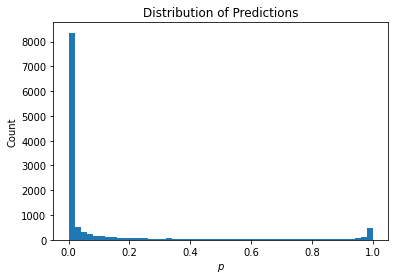

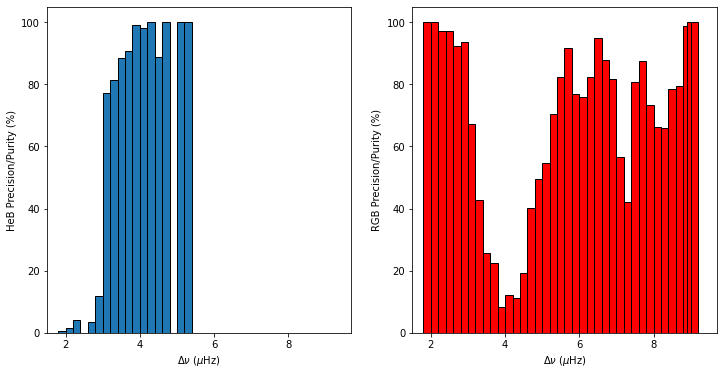

Length Plotted:  11950
Unique Epistemic:  7777
Unique Total:  7583
Total with sigma above 0.1:  3689
(5363,)


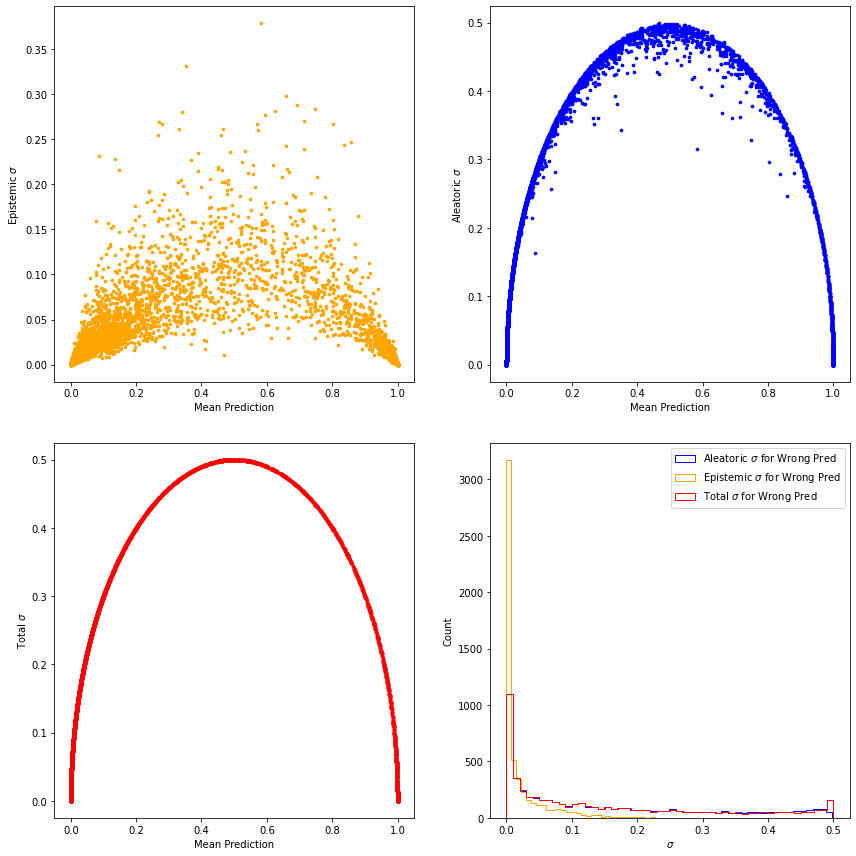

In [5]:
test_single=False
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/82d_ACC:94.03-Loss:63.665'
saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/365d_Downweight_LLRGB_ConsensusNoVal_Epoch246_LLRGB_ACC:98.42-Loss:194.622'

trained_model = Bayes_Classifier()
trained_model.load_state_dict(torch.load(saved_model_dict))
trained_model.cuda()
trained_model.eval()
torch.backends.cudnn.benchmark = True

test_pred = []
test_truth = []
test_mean = []
test_dnu_vec = []
test_aleatoric = []
test_epistemic = []

test_file = '/data/marc/AstroBlasto/Single_Perturb_Datasets/JieCollapsedSpectra(82daysCopy)RealisticDnu.csv'
if test_single:
    test_KIC_file = '/home/z3384751/AstroBlasto/TestKIC(GOTY).txt'
    test_data = pd.read_table(test_KIC_file, header=None)
    leave_out_kic = test_data.iloc[:].values
    print('Number of Leave Out KIC in catalog: ', len(leave_out_kic))

    print('Testing Single Perturb Dataset...')
    test_data = pd.read_csv(test_file, header=None)
    X = test_data.iloc[:, 0:2000].values.astype(float)
    kic = test_data.iloc[:, 2000].values
    Y = test_data.iloc[:, 2001].values
    dnu = test_data.iloc[:, 2002].values  # use this for non 4-year sets
    row_max = np.max(X, axis=1)
    for i in range(len(X)):
        if row_max[i] == 0:
            print('Zero entry detected!')  # Data checking
        X[i] = X[i] / row_max[i]  # normalizing each row

    X_test = X[np.in1d(kic, leave_out_kic)]
    kic_test = kic[np.in1d(kic, leave_out_kic)]
    dnu_test = dnu[np.in1d(kic, leave_out_kic)]
    Y_test = Y[np.in1d(kic, leave_out_kic)]

    testX = torch.stack([torch.Tensor(i) for i in X_test])  # convert to torch Tensor
    testY = torch.stack([torch.Tensor(i) for i in [Y_test]]).permute(1, 0)  # convert to torch Tensor
    testdnu = torch.stack([torch.Tensor(i) for i in [dnu_test]]).permute(1, 0)  # convert to torch Tensor
    testflag = torch.zeros(testY.size()).squeeze()

    test_dataset = utils.TensorDataset(testX, testY, testdnu, testflag)
    test_dataloader = utils.DataLoader(test_dataset, shuffle=True, batch_size=32)

else:
    folder_kic = []
    root_folder = '/data/marc/AstroBlasto/npz_BGCorr/BGCorrSpectra(82days-Consensus)/'
    for dirpath, dirnames, filenames in os.walk(root_folder):
        for filex in filenames:
            folder_kic.append(int(filex.split('-')[0]))

    folder_kic = np.unique(folder_kic)
    train_kics, test_kics = train_test_split(folder_kic, test_size=0.15, random_state=137)

    test_gen = npz_generator(root=root_folder, select_kic=test_kics, obs_len=82)
    test_dataloader = utils.DataLoader(test_gen, shuffle=True, batch_size=32, num_workers=8)

test_loss = 0
mc_samples = 10
for batch_idz, test_data in tqdm(enumerate(test_dataloader, 0), total=len(
        test_dataloader)):  # indices,scaled_indices, numax, teff, fe_h, age, tams_age
    test_image = test_data[0].cuda().float()
    test_label = test_data[1].cuda().long().squeeze(1)
    test_dnu = test_data[2].cuda().float()
    test_flag = test_data[3].cuda().float()

    test_image = test_image[test_flag != 1]
    test_label = test_label[test_flag != 1]
    test_dnu = test_dnu[test_flag != 1]

    if len(test_label) < 1:
        continue

    pred_grid = np.empty((mc_samples, test_label.shape[0], 2))
    with torch.no_grad():
        for i in range(mc_samples):
            outputs, kl = trained_model.probforward(test_image, test_dnu)
            pred_grid[i, :] = F.softmax(outputs, dim=1).data.cpu().numpy()
    pred_mean = np.mean(pred_grid, axis=0)
    epistemic = np.mean(pred_grid ** 2, axis=0) - np.mean(pred_grid, axis=0) ** 2
    aleatoric = np.mean(pred_grid * (1 - pred_grid), axis=0)

    pred = np.argmax(pred_mean, axis=1)
    pred_epi = epistemic[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]
    pred_alea = aleatoric[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]

    test_mean.append(pred_mean[np.arange(len(pred)), 1])
    test_pred.append(pred)
    test_aleatoric.append(pred_alea)
    test_epistemic.append(pred_epi)
    test_truth.append(test_label.data.cpu().numpy())
    test_dnu_vec.append(test_dnu)
test_mean = np.concatenate(test_mean, axis=0)
test_pred = np.concatenate(test_pred, axis=0)
test_truth = np.concatenate(test_truth, axis=0)
test_dnu_vec = np.concatenate(test_dnu_vec, axis=0)
test_aleatoric = np.concatenate(test_aleatoric, axis=0)
test_epistemic = np.concatenate(test_epistemic, axis=0)

print('Accuracy: ', accuracy_score(y_true=test_truth, y_pred=test_pred))
print('Test Loss: ', test_loss)
print('Recall: ', recall_score(y_true=test_truth, y_pred=test_pred))
print('Precision: ', precision_score(y_true=test_truth, y_pred=test_pred))
print('Confusion Matrix: \n', confusion_matrix(y_true=test_truth, y_pred=test_pred))

bins = np.linspace(2.0, 9.2, num=37)
diff_bins = bins[:-1] - 0.5 * np.diff(bins)
digitized_dnu = np.digitize(test_dnu_vec, bins=bins)
while len(np.unique(digitized_dnu)) != len(diff_bins):
    diff_bins = np.append(diff_bins, diff_bins[-1] + 0.5 * (diff_bins[1] - diff_bins[0]))
print('Diff Bins: ', diff_bins)

accuracy_vector = []
precision_vector_pos = []
precision_vector_neg = []
print('Test Pred Shape: ', test_pred.shape)
print('Digitized Dnu Shape: ', digitized_dnu.shape)
test_pred = test_pred.squeeze()
test_truth = test_truth.squeeze()
test_mean = test_mean.squeeze()
digitized_dnu = digitized_dnu.squeeze()
for val in np.unique(digitized_dnu):
    print('Evaluating Dnu: ', test_dnu_vec[digitized_dnu == val][0])
    select_pred_label = test_pred[digitized_dnu == val]
    select_truth_label = test_truth[digitized_dnu == val]
    select_proba = test_mean[digitized_dnu == val]
    accuracy_vector.append(np.sum(np.abs(select_pred_label - select_truth_label)) / len(select_truth_label))
    precision_vector_pos.append(precision_score(y_pred=select_pred_label, y_true=select_truth_label, pos_label=1))
    precision_vector_neg.append(precision_score(y_pred=select_pred_label, y_true=select_truth_label, pos_label=0))
accuracy_vector = np.array(accuracy_vector) * 100
precision_vector_pos = np.array(precision_vector_pos) * 100
precision_vector_neg = np.array(precision_vector_neg) * 100

plt.hist(test_mean, bins=50)
plt.title('Distribution of Predictions')
plt.xlabel('$p$')
plt.ylabel('Count')
plt.show()
plt.close()

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.bar(diff_bins,
        precision_vector_pos, edgecolor='k', width=np.median(np.diff(bins)))

ax1.set_ylabel('HeB Precision/Purity (%)')
ax1.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)')

ax2.bar(diff_bins,
        precision_vector_neg, edgecolor='k', width=np.median(np.diff(bins)),
        color='red')

ax2.set_ylabel('RGB Precision/Purity (%)')
ax2.set_xlabel('$\\Delta\\nu$ ($\\mu$Hz)')
ax1.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18])
ax2.set_xticks([2, 4, 6, 8, 10, 12, 14, 16, 18])
ax1.set_xlim([1.5, 9.7])
ax2.set_xlim([1.5, 9.7])

plt.show()
plt.close()

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax1.scatter(test_mean, np.sqrt(test_epistemic), s=7, c='orange')
ax1.set_xlabel('Mean Prediction')
ax1.set_ylabel('Epistemic $\\sigma$')
ax2.scatter(test_mean, np.sqrt(test_aleatoric), s=7, c='blue')
print('Length Plotted: ', len(test_aleatoric))
print('Unique Epistemic: ', len(np.unique(test_epistemic)))
ax2.set_xlabel('Mean Prediction')
ax2.set_ylabel('Aleatoric $\\sigma$')

ax3.scatter(test_mean, np.sqrt(test_epistemic + test_aleatoric), s=7, c='r')
print('Unique Total: ', len(np.unique(np.sqrt(test_epistemic + test_aleatoric))))

ax3.set_xlabel('Mean Prediction')
ax3.set_ylabel('Total $\\sigma$')
print('Total with sigma above 0.1: ', np.sum(np.sqrt(test_epistemic + test_aleatoric) > 0.1))

wrong_aleatoric = test_aleatoric[np.abs(test_truth - test_pred) == 1]
wrong_epistemic = test_epistemic[np.abs(test_truth - test_pred) == 1]
print(wrong_aleatoric.shape)
ax4.hist(np.sqrt(wrong_aleatoric), histtype='step', bins=50, color='blue',
         label='Aleatoric $\\sigma$ for Wrong Pred')
ax4.hist(np.sqrt(wrong_epistemic), histtype='step', bins=50, color='orange',
         label='Epistemic $\\sigma$ for Wrong Pred')
ax4.hist(np.sqrt(wrong_aleatoric + wrong_epistemic), histtype='step', bins=50, color='red',
         label='Total $\\sigma$ for Wrong Pred')
ax4.legend()
ax4.set_ylabel('Count')
ax4.set_xlabel('$\\sigma$')
plt.tight_layout(w_pad=3, h_pad=3)
plt.show()

# Applying this on real data

## For Okayama we used 
saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/365d_Downweight_LLRGB_ConsensusNoVal_Epoch246_LLRGB_ACC:98.42-Loss:194.622'

for 3month, 6month, > 1 yr

and # saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_Downweight_LLRGB_ConsensusNoVal_Epoch54_LLRGB_ACC:91.81-Loss:10.395'
 for anything with 2 months or less

In [232]:
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_Downweight_LLRGB_ConsensusNoVal_Epoch54_LLRGB_ACC:91.81-Loss:10.395'
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/82sConsensusNoVal_LLRGB_ACC:94.02-Loss:23.731'

saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/365d_Downweight_LLRGB_ConsensusNoVal_Epoch246_LLRGB_ACC:98.42-Loss:194.622'

trained_model = Bayes_Classifier()
trained_model.load_state_dict(torch.load(saved_model_dict))
trained_model.cuda()
trained_model.eval()
torch.backends.cudnn.benchmark = True

In [233]:
spec_data = pd.read_csv('/home/z3384751/AstroBlasto/Okayama/folded_spectra/sn_3mnth_folded_spectrum_smoothed.csv', header=None)
spec_data.shape

X = spec_data.iloc[:, 0:2000].values.astype(float)
kic = spec_data.iloc[:, 2000].values

dnu = spec_data.iloc[:, 2001].values  # use this for non 4-year sets
row_max = np.max(X, axis=1)
for i in range(len(X)):
    if row_max[i] == 0:
        print('Zero entry detected!')  # Data checking
    X[i] = X[i] / row_max[i]  # normalizing each row

    
testX = torch.stack([torch.Tensor(i) for i in X])  # convert to torch Tensor
testdnu = torch.stack([torch.Tensor(i) for i in [dnu]]).permute(1, 0)  # convert to torch Tensor

test_dataset = utils.TensorDataset(testX, testdnu)
test_dataloader = utils.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [234]:
test_pred = []
test_truth = []
test_mean = []
test_dnu_vec = []
test_aleatoric = []
test_epistemic = []


mc_samples = 100
for batch_idz, test_data in tqdm(enumerate(test_dataloader, 0), total=len(
        test_dataloader)):  # indices,scaled_indices, numax, teff, fe_h, age, tams_age
    test_image = test_data[0].cuda().float()
    test_dnu = test_data[1].cuda().float()
        
    pred_grid = np.empty((mc_samples, test_image.shape[0], 2))
    with torch.no_grad():
        for i in range(mc_samples):
            outputs, kl = trained_model.probforward(test_image, test_dnu)
            pred_grid[i, :] = F.softmax(outputs, dim=1).data.cpu().numpy()
    pred_mean = np.mean(pred_grid, axis=0)
    epistemic = np.mean(pred_grid ** 2, axis=0) - np.mean(pred_grid, axis=0) ** 2
    
    pred = np.argmax(pred_mean, axis=1)
    pred_epi = epistemic[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]
    
    test_mean.append(pred_mean[np.arange(len(pred)), 1])
    test_pred.append(pred)
    test_epistemic.append(pred_epi)
    test_dnu_vec.append(test_dnu)

test_mean = np.concatenate(test_mean, axis=0)
test_pred = np.concatenate(test_pred, axis=0)
test_dnu_vec = np.squeeze(np.concatenate(test_dnu_vec, axis=0))
test_epistemic = np.concatenate(test_epistemic, axis=0)
test_calib_pred = []
for k in range(len(test_mean)): # thresholds are 0.567 - 4 years; 0.442 - 1 year; 0.503 - 82days; 0.533 - 30 days
    if test_mean[k] >= 0.533:
       test_calib_pred.append(1)
    else:
       test_calib_pred.append(0)
test_calib_pred = np.array(test_calib_pred)
test_calib_pred[test_dnu_vec > 9.5] = 0

100%|██████████| 3/3 [00:04<00:00,  1.35s/it]


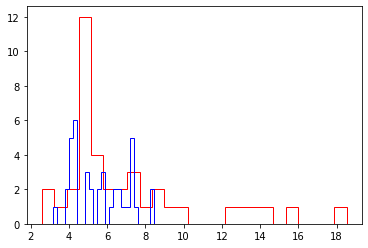

In [235]:
plt.hist(test_dnu_vec[test_calib_pred == 0], bins=25, histtype='step', color='red')
plt.hist(test_dnu_vec[test_calib_pred == 1], bins=25, histtype='step', color='blue')
plt.show()

In [238]:
for i in range(len(kic)):
    print(int(kic[i]), test_calib_pred[i], test_mean[i], test_epistemic[i])

468901651 0 1.8418329160603263e-05 7.016952574545599e-10
1828620 1 0.9795164227485657 6.943838702688776e-05
3095329 1 0.9578669339418411 0.0006327804963283112
8395677 0 3.9336954155385064e-10 0.0
10167479 0 0.007304302011616528 6.0587700028147395e-06
18229450 1 0.9999997174739838 3.099742684753437e-13
24664982 0 9.473568631725342e-14 0.0
26693841 0 0.001411726444894157 2.5881275648176327e-06
28912737 0 6.097818253181231e-07 8.451017663446692e-13
39200298 1 0.9990419393777847 2.2459520132578348e-07
39429875 0 0.17567071355879307 0.0028904233421848113
48447365 1 0.9991934525966645 3.46577117227298e-07
57192070 1 0.6964910626411438 0.005163642870939511
63456028 0 0.0009974568303641718 2.6348601239734037e-06
64105644 0 0.0002471555015517879 6.488763870660108e-08
64526513 1 0.9998582994937897 1.0546303941261215e-08
67784488 1 0.7172075042966753 0.07491135980583585
69362245 1 0.9617499738931656 0.000870489693497567
85911344 0 0.09235962949693204 0.0007992841308576137
87674484 1 0.99890622556

In [ ]:
# 364255453 # bad spike

In [237]:
with open('/home/z3384751/AstroBlasto/Okayama/results/sn_3mnth_smoothed_results.dat', 'a') as writer:
    writer.write('TIC,prob,ev_state,delta_nu\n')
    for i in range(len(test_mean)):
        writer.write(str(int(kic[i]))+','+str(np.round(test_mean[i],3)) + \
                     ',' + str(int(test_calib_pred[i]))  + ',' + str(np.round(test_dnu_vec[i],2)) +'\n')
    

# Applying this to TESS-CVZ_Feb2023 at /home/z3384751/AstroBlasto/TESS-CVZ_Feb2023/

For the long dataset (T > 150 d), we use: 

 '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/365d_Downweight_LLRGB_ConsensusNoVal_Epoch246_LLRGB_ACC:98.42-Loss:194.622'
 
For the long dataset (T > 27 d), we use: 
'/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_ACC:94.95-Loss:48.094'
Similar result:

'/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_Downweight_LLRGB_ConsensusNoVal_Epoch54_LLRGB_ACC:91.81-Loss:10.395'


In [68]:
saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/365d_Downweight_LLRGB_ConsensusNoVal_Epoch246_LLRGB_ACC:98.42-Loss:194.622'
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/82sConsensusNoVal_LLRGB_ACC:94.02-Loss:23.731'
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_Downweight_LLRGB_ConsensusNoVal_Epoch54_LLRGB_ACC:91.81-Loss:10.395'
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_ACC:94.95-Loss:48.094'


trained_model = Bayes_Classifier()
trained_model.load_state_dict(torch.load(saved_model_dict))
trained_model.cuda()
trained_model.eval()
torch.backends.cudnn.benchmark = True

In [73]:
spec_data = pd.read_csv('/home/z3384751/AstroBlasto/TESS-CVZ_Feb2023/MultSec_121121_Salvage_FoldedSpectra.csv', header=None)
spec_data.shape

X = spec_data.iloc[:, 0:2000].values.astype(float)
kic = spec_data.iloc[:, 2000].values

dnu = spec_data.iloc[:, 2001].values  # use this for non 4-year sets
row_max = np.max(X, axis=1)
for i in range(len(X)):
    if row_max[i] == 0:
        print('Zero entry detected!')  # Data checking
    X[i] = X[i] / row_max[i]  # normalizing each row

    
testX = torch.stack([torch.Tensor(i) for i in X])  # convert to torch Tensor
testdnu = torch.stack([torch.Tensor(i) for i in [dnu]]).permute(1, 0)  # convert to torch Tensor

test_dataset = utils.TensorDataset(testX, testdnu)
test_dataloader = utils.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [74]:
test_pred = []
test_truth = []
test_mean = []
test_dnu_vec = []
test_aleatoric = []
test_epistemic = []


mc_samples = 100
for batch_idz, test_data in tqdm(enumerate(test_dataloader, 0), total=len(
        test_dataloader)):  # indices,scaled_indices, numax, teff, fe_h, age, tams_age
    test_image = test_data[0].cuda().float()
    test_dnu = test_data[1].cuda().float()
        
    pred_grid = np.empty((mc_samples, test_image.shape[0], 2))
    with torch.no_grad():
        for i in range(mc_samples):
            outputs, kl = trained_model.probforward(test_image, test_dnu)
            pred_grid[i, :] = F.softmax(outputs, dim=1).data.cpu().numpy()
    pred_mean = np.mean(pred_grid, axis=0)
    epistemic = np.mean(pred_grid ** 2, axis=0) - np.mean(pred_grid, axis=0) ** 2
    
    pred = np.argmax(pred_mean, axis=1)
    pred_epi = epistemic[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]
    
    test_mean.append(pred_mean[np.arange(len(pred)), 1])
    test_pred.append(pred)
    test_epistemic.append(pred_epi)
    test_dnu_vec.append(test_dnu)

test_mean = np.concatenate(test_mean, axis=0)
test_pred = np.concatenate(test_pred, axis=0)
test_dnu_vec = np.squeeze(np.concatenate(test_dnu_vec, axis=0))
test_epistemic = np.concatenate(test_epistemic, axis=0)
test_calib_pred = []
for k in range(len(test_mean)): # thresholds are 0.567 - 4 years; 0.442 - 1 year; 0.503 - 82days; 0.533 - 30 days
    if test_mean[k] >= 0.533:
       test_calib_pred.append(1)
    else:
       test_calib_pred.append(0)
test_calib_pred = np.array(test_calib_pred)
# test_calib_pred[test_dnu_vec > 9.5] = 0

100%|██████████| 1/1 [00:01<00:00,  1.33s/it]


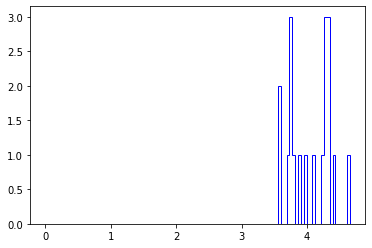

In [75]:
plt.hist(test_dnu_vec[test_calib_pred == 0], bins=25, histtype='step', color='red')
plt.hist(test_dnu_vec[test_calib_pred == 1], bins=25, histtype='step', color='blue')
plt.show()

In [76]:
with open('/home/z3384751/AstroBlasto/TESS-CVZ_Feb2023/MultSec_121121_Salvage_EvState_results.dat', 'a') as writer:
    writer.write('TIC,prob,ev_state,delta_nu\n')
    for i in range(len(test_mean)):
        writer.write(str(int(kic[i]))+','+str(np.round(test_mean[i],3)) + \
                     ',' + str(int(test_calib_pred[i]))  + ',' + str(np.round(test_dnu_vec[i],2)) +'\n')

# Applying this to single-sector stars for Veloce_May2023 at /home/z3384751/AstroBlasto/VeloceTESS_May2023/


In [47]:
saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_ACC:94.95-Loss:48.094'


trained_model = Bayes_Classifier()
trained_model.load_state_dict(torch.load(saved_model_dict))
trained_model.cuda()
trained_model.eval()
torch.backends.cudnn.benchmark = True

In [53]:
spec_data = pd.read_csv('/home/z3384751/AstroBlasto/VeloceTESS_May2023/SingleSector_S13_Short_FP0_FoldedSpectra.csv', header=None)
spec_data.shape

X = spec_data.iloc[:, 0:2000].values.astype(float)
kic = spec_data.iloc[:, 2000].values

dnu = spec_data.iloc[:, 2001].values  # use this for non 4-year sets
row_max = np.max(X, axis=1)
for i in range(len(X)):
    if row_max[i] == 0:
        print('Zero entry detected!')  # Data checking
    X[i] = X[i] / row_max[i]  # normalizing each row

    
testX = torch.stack([torch.Tensor(i) for i in X])  # convert to torch Tensor
testdnu = torch.stack([torch.Tensor(i) for i in [dnu]]).permute(1, 0)  # convert to torch Tensor

test_dataset = utils.TensorDataset(testX, testdnu)
test_dataloader = utils.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [54]:
test_pred = []
test_truth = []
test_mean = []
test_dnu_vec = []
test_aleatoric = []
test_epistemic = []


mc_samples = 100
for batch_idz, test_data in tqdm(enumerate(test_dataloader, 0), total=len(
        test_dataloader)):  # indices,scaled_indices, numax, teff, fe_h, age, tams_age
    test_image = test_data[0].cuda().float()
    test_dnu = test_data[1].cuda().float()
        
    pred_grid = np.empty((mc_samples, test_image.shape[0], 2))
    with torch.no_grad():
        for i in range(mc_samples):
            outputs, kl = trained_model.probforward(test_image, test_dnu)
            pred_grid[i, :] = F.softmax(outputs, dim=1).data.cpu().numpy()
    pred_mean = np.mean(pred_grid, axis=0)
    epistemic = np.mean(pred_grid ** 2, axis=0) - np.mean(pred_grid, axis=0) ** 2
    
    pred = np.argmax(pred_mean, axis=1)
    pred_epi = epistemic[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]
    
    test_mean.append(pred_mean[np.arange(len(pred)), 1])
    test_pred.append(pred)
    test_epistemic.append(pred_epi)
    test_dnu_vec.append(test_dnu)

test_mean = np.concatenate(test_mean, axis=0)
test_pred = np.concatenate(test_pred, axis=0)
test_dnu_vec = np.squeeze(np.concatenate(test_dnu_vec, axis=0))
test_epistemic = np.concatenate(test_epistemic, axis=0)
test_calib_pred = []
for k in range(len(test_mean)): # thresholds are 0.567 - 4 years; 0.442 - 1 year; 0.503 - 82days; 0.533 - 30 days
    if test_mean[k] >= 0.533:
       test_calib_pred.append(1)
    else:
       test_calib_pred.append(0)
test_calib_pred = np.array(test_calib_pred)
# test_calib_pred[test_dnu_vec > 9.5] = 0

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]


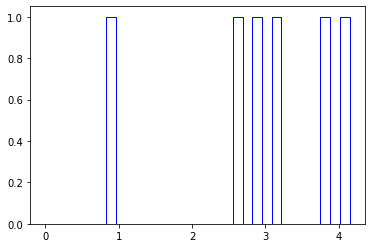

In [55]:
plt.hist(test_dnu_vec[test_calib_pred == 0], bins=25, histtype='step', color='red')
plt.hist(test_dnu_vec[test_calib_pred == 1], bins=25, histtype='step', color='blue')
plt.show()

In [56]:
test_calib_pred

array([1, 1, 1, 1, 1, 1])

In [57]:
# with open('/home/z3384751/AstroBlasto/VeloceTESS_May2023/SingleSector_S13_30d_old_CLASSIFIER.dat', 'a') as writer:
#     writer.write('TIC,prob,ev_state,delta_nu\n')
#     for i in range(len(test_mean)):
#         writer.write(str(int(kic[i]))+','+str(np.round(test_mean[i],3)) + \
#                      ',' + str(int(test_calib_pred[i]))  + ',' + str(np.round(test_dnu_vec[i],2)) +'\n')

# Applying this to Kepler-TESS stars at /home/z3384751/AstroBlasto/Kepler-TESS-Testing_May2023/


In [63]:
# saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_ACC:94.95-Loss:48.094' #30d old
saved_model_dict = '/home/z3384751/AstroBlasto/saved_models/OTF_Pytorch/27d_Downweight_LLRGB_ConsensusNoVal_Epoch54_LLRGB_ACC:91.81-Loss:10.395'
# 30d new

trained_model = Bayes_Classifier()
trained_model.load_state_dict(torch.load(saved_model_dict))
trained_model.cuda()
trained_model.eval()
torch.backends.cudnn.benchmark = True

In [64]:
spec_data = pd.read_csv('/home/z3384751/AstroBlasto/Kepler-TESS-Testing_May2023/Kepler-TESS_FoldedSpectra_(TESSParams).csv', header=None)
spec_data.shape

X = spec_data.iloc[:, 0:2000].values.astype(float)
kic = spec_data.iloc[:, 2000].values

dnu = spec_data.iloc[:, 2001].values  # use this for non 4-year sets
row_max = np.max(X, axis=1)
for i in range(len(X)):
    if row_max[i] == 0:
        print('Zero entry detected!')  # Data checking
    X[i] = X[i] / row_max[i]  # normalizing each row

    
testX = torch.stack([torch.Tensor(i) for i in X])  # convert to torch Tensor
testdnu = torch.stack([torch.Tensor(i) for i in [dnu]]).permute(1, 0)  # convert to torch Tensor

test_dataset = utils.TensorDataset(testX, testdnu)
test_dataloader = utils.DataLoader(test_dataset, shuffle=False, batch_size=32)

In [65]:
test_pred = []
test_truth = []
test_mean = []
test_dnu_vec = []
test_aleatoric = []
test_epistemic = []


mc_samples = 100
for batch_idz, test_data in tqdm(enumerate(test_dataloader, 0), total=len(
        test_dataloader)):  # indices,scaled_indices, numax, teff, fe_h, age, tams_age
    test_image = test_data[0].cuda().float()
    test_dnu = test_data[1].cuda().float()
        
    pred_grid = np.empty((mc_samples, test_image.shape[0], 2))
    with torch.no_grad():
        for i in range(mc_samples):
            outputs, kl = trained_model.probforward(test_image, test_dnu)
            pred_grid[i, :] = F.softmax(outputs, dim=1).data.cpu().numpy()
    pred_mean = np.mean(pred_grid, axis=0)
    epistemic = np.mean(pred_grid ** 2, axis=0) - np.mean(pred_grid, axis=0) ** 2
    
    pred = np.argmax(pred_mean, axis=1)
    pred_epi = epistemic[np.arange(len(pred)), np.argmax(pred_mean, axis=1)]
    
    test_mean.append(pred_mean[np.arange(len(pred)), 1])
    test_pred.append(pred)
    test_epistemic.append(pred_epi)
    test_dnu_vec.append(test_dnu)

test_mean = np.concatenate(test_mean, axis=0)
test_pred = np.concatenate(test_pred, axis=0)
test_dnu_vec = np.squeeze(np.concatenate(test_dnu_vec, axis=0))
test_epistemic = np.concatenate(test_epistemic, axis=0)
test_calib_pred = []
for k in range(len(test_mean)): # thresholds are 0.567 - 4 years; 0.442 - 1 year; 0.503 - 82days; 0.533 - 30 days
    if test_mean[k] >= 0.533:
       test_calib_pred.append(1)
    else:
       test_calib_pred.append(0)
test_calib_pred = np.array(test_calib_pred)
# test_calib_pred[test_dnu_vec > 9.5] = 0

100%|██████████| 18/18 [00:25<00:00,  1.44s/it]


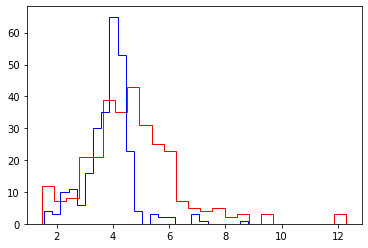

In [66]:
plt.hist(test_dnu_vec[test_calib_pred == 0], bins=25, histtype='step', color='red')
plt.hist(test_dnu_vec[test_calib_pred == 1], bins=25, histtype='step', color='blue')
plt.show()

In [67]:
# with open('/home/z3384751/AstroBlasto/Kepler-TESS-Testing_May2023/Kepler-TESS_30d_new_CLASSIFIER.dat', 'a') as writer:
#     writer.write('TIC,prob,ev_state,delta_nu\n')
#     for i in range(len(test_mean)):
#         writer.write(str(int(kic[i]))+','+str(np.round(test_mean[i],3)) + \
#                      ',' + str(int(test_calib_pred[i]))  + ',' + str(np.round(test_dnu_vec[i],2)) +'\n')